In [1]:
import numpy as np

In [2]:
%env JAX_ENABLE_X64=True

env: JAX_ENABLE_X64=True


In [3]:
from lenstronomy.LensModel.lens_model import LensModel
import lensinggw.constants.constants as const
from lensinggw.utils.utils import TimeDelay, magnifications, getMinMaxSaddle

In [4]:
# import sys
# import os
# path = os.getcwd()
# dir = '/mnt/c/users/simon/microlensing/wolensing_simon/wolensing/wolensing/'
# sys.path.append(dir)

In [5]:
# from plot.plot import plot_contour
import wolensing.amplification_factor.amplification_factor as af
from wolensing.lensmodels.potential import potential

In [6]:
# !pip install SciencePLots

In [7]:
import matplotlib.pyplot as plt
# import scienceplots
# plt.style.use('science')

The macroimage where the microlens is placed around.

In [8]:
type2 = False

In [9]:
ym = 0.8
angle = np.radians(float(0))

Importing constants

In [10]:
G = const.G  # gravitational constant [m^3 kg^-1 s^-2]
c = const.c  # speed of light [m/s]
M_sun = const.M_sun  # Solar mass [Kg]

In [11]:
y0, y1 = 0.5, 0 # source position
l0, l1 = 0., 0 # lens position

zS = 1.0 # source redshift
zL = 0.5 # lens redshift

In [12]:
mL1 = 1e10
mL2 = 20
mtot = mL1 + mL2

# convert to radians
from lensinggw.utils.utils import param_processing
thetaE1 = param_processing(zL, zS, mL1)
thetaE2 = param_processing(zL, zS, mL2)
thetaE = param_processing(zL, zS, mtot)

In [13]:
ts = np.loadtxt('data_otto/0.4_ts.txt')
Ft = np.loadtxt('data_otto/0.4_Ft.txt')

In [14]:
ticks = np.linspace(0, 2e-8, 4)

In [15]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

def iden_log_peak(y):
    y_smooth = gaussian_filter1d(y, sigma=1)
    peaks, properties = find_peaks(y_smooth, height=0.5, distance=10, prominence=0.1)

    return peaks

def iden_discontinuities(x, y):
    peaks, _ = find_peaks(y, prominence=0.5, distance=10)
    
    dy = np.diff(y)
    dx = np.diff(x)
    gradient = dy / dx
    
    # Set a threshold to detect sharp changes (potential discontinuities)
    threshold = np.percentile(np.abs(gradient), 99.99)  # Top 5% of changes
    potential_discontinuities = np.where(np.abs(gradient) > threshold)[0]
    
    # Remove points near peaks
    peak_mask = np.zeros_like(gradient, dtype=bool)
    for peak in peaks:
        peak_mask[max(0, peak - 10):min(len(gradient), peak + 10)] = True
    
    discontinuities = [idx for idx in potential_discontinuities if not peak_mask[idx]]

    return discontinuities
    

In [16]:
args2 = iden_log_peak(Ft)
args1 = iden_discontinuities(ts, Ft)

args1 = np.array([args1[0], args1[-1]+2])

args = np.concatenate((args1, args2))

threshold = 2  # Minimum distance between points
filtered_points = [args[0]]  # Start with the first point

for i in range(1, len(args)):
    dist = np.linalg.norm(args[i] - filtered_points[-1])  # Euclidean distance
    if dist >= threshold:
        filtered_points.append(args[i])

args = np.array(filtered_points)

In [17]:
args

array([  0,  58,  85, 185])

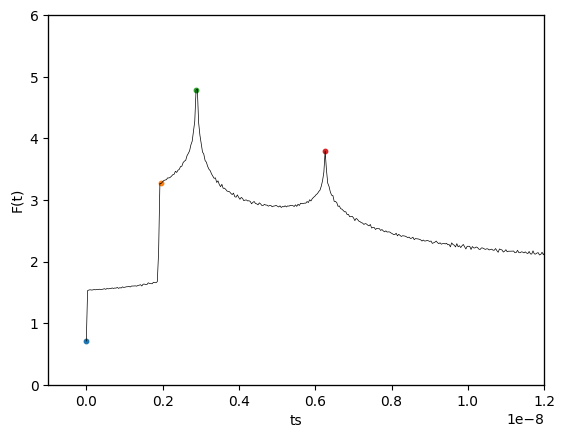

In [18]:
plt.plot(ts, Ft, color = 'black', linewidth=0.5)
plt.xlim(-1e-9, 0.12e-7)
plt.ylim(0, 6)
plt.xlabel(r'ts')
for arg in args:
    plt.scatter(ts[arg], Ft[arg], s=10)
from matplotlib.ticker import MaxNLocator
ax = plt.gca()

ax2 = ax.twiny()  # for the second x-axis
ax3 = ax.twinx()  # for the second y-axis

# Remove ticks and labels from the second x-axis (top)
ax2.set_xticks([])  # Remove ticks
ax2.set_xticklabels([])  # Remove tick labels

# Remove ticks and labels from the second y-axis (right)
ax3.set_yticks([])  # Remove ticks
ax3.set_yticklabels([])  # Remove tick labels

ax.set_ylabel('F(t)')
plt.savefig('Ft.pdf', dpi=300)

In [19]:
Mpc=3.085677581491367e+22
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=69.7, Om0=0.306, Tcmb0=2.725)
DL       = cosmo.angular_diameter_distance(zL)
DS       = cosmo.angular_diameter_distance(zS)
DLS      = cosmo.angular_diameter_distance_z1z2(zL, zS)
D        = DLS/(DL*DS)
print(np.float64(D/Mpc))

1.097926071881248e-26


In [20]:
from wolensing.utils.utils import Einstein_radius

In [21]:
Einstein_radius(zL, zS, mtot)

141457.81166301022

In [22]:
beta0, beta1 = y0 * thetaE, y1 * thetaE
eta10, eta11 = 0 * l0 * thetaE, 0 * l1 * thetaE
lens_model_list = ['SIS']
kwargs_sis_1 = {'center_x': eta10, 'center_y': eta11, 'theta_E': thetaE1}
kwargs_lens_list = [kwargs_sis_1]

kwargs_sis_1_scaled = {'center_x': eta10 / thetaE, 'center_y': eta11 / thetaE, 'theta_E': thetaE1 / thetaE}
kwargs_lens_list_scaled = [kwargs_sis_1_scaled]

from lensinggw.solver.images import microimages
solver_kwargs = {'SearchWindowMacro': 10 * thetaE1,
                 'SearchWindow': 5 * thetaE2,
                 'OverlapDistMacro': 1e-17,
                 'OnlyMacro': True}
MacroImg_ra, MacroImg_dec, pixel_width = microimages(source_pos_x=beta0,
                                                     source_pos_y=beta1,
                                                     lens_model_list=lens_model_list,
                                                     kwargs_lens=kwargs_lens_list,
                                                     **solver_kwargs)

Td = TimeDelay(MacroImg_ra, MacroImg_dec,
                beta0, beta1,
                zL, zS,
                lens_model_list, kwargs_lens_list)
Mus = magnifications(MacroImg_ra, MacroImg_dec, lens_model_list, kwargs_lens_list)
if type2:
    microtype = np.nonzero(Td)[0][0]
else:
    microtype = np.where(Td==0)[0][0]


---- Will perform only the macromodel analysis ----

---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro         --> True
Scaled            --> False
SearchWindowMacro --> 8.052888061582412e-06
PixelsMacro       --> 1000
PrecisionLimit    --> 1e-20
OverlapDistMacro  --> 1e-17
NearSource        --> False
Optimization      --> False
Verbose           --> False



/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:107: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:107: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:108: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:117: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:117: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packa




MACROIMAGES

ra: [-4.02644403e-07  1.20793321e-06]
dec: [-4.23516474e-22 -4.23516474e-22]



In [23]:
masses = [60]
angle = [45]
ym = [0.4, 0.6, 0.7]
# ym = [0.4]

from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.lens_model import LensModel

num_points = len(ym)

from lensinggw.utils.utils import TimeDelay, magnifications, getMinMaxSaddle
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions

img_x, img_y = [], []
mus = []
for j in range(len(ym)):
    theta_E = param_processing(zL, zS, masses[0])# lens model
    #positioning the microlenses
    lens_model_list = ['SIS']
    kwargs_sis_1 = {'center_x': eta10, 'center_y': eta11, 'theta_E': thetaE1}
    kwargs_lens_list = [kwargs_sis_1]
    eta20 = MacroImg_ra[microtype] + ym[j]*np.cos(np.radians(45)) * theta_E
    eta21 = MacroImg_dec[microtype] + ym[j] * np.sin(np.radians(45)) * theta_E
    lens_model_list.append('POINT_MASS')
    kwargs_lens_list.append({'center_x': eta20, 'center_y': eta21, 'theta_E': theta_E})

  
    lensmodel = LensModel(lens_model_list=lens_model_list)
    solver = LensEquationSolver(
        lensModel = lensmodel
    )
    Img_ra, Img_dec = solver.image_position_stochastic(
        source_x = beta0,
        source_y = beta1,
        kwargs_lens = kwargs_lens_list,
        # min_distance = 1e-13,
        # solver='lenstronomy'
        search_window = 20*thetaE2,
        # verbose=True,
        precision_limit=10**(-17),
        x_center = MacroImg_ra[microtype],
        y_center= MacroImg_dec[microtype]
    )

    img_x.append(Img_ra)
    img_y.append(Img_dec)
    mus.append(magnifications(Img_ra, Img_dec, lens_model_list, kwargs_lens_list))

    lens_model_complete = LensModel(lens_model_list=lens_model_list)
    T = lens_model_complete.fermat_potential
    T0 = thetaE ** (-2) * T(Img_ra[microtype], Img_dec[microtype], kwargs_lens_list, beta0, beta1)#[0]

    # fig1, ax1 = plt.subplots()
    # plot_contour(ax1, lens_model_list, MacroImg_ra[microtype], MacroImg_dec[microtype], 20*thetaE2, kwargs_lens_list, beta0, beta1, Img_ra, Img_dec,
    #                 T0 = T0, Tfac = (thetaE)**(-2), micro=True)
    # plt.savefig(f'./{ym[j]}_ts.png')
    # plt.close()

    lens_model_complete = LensModel(lens_model_list=lens_model_list)
    lensmodelext = LensModelExtensions(lens_model_complete)
    
colorlist = ['green', 'darkcyan', 'red']


lens_model_complete = LensModel(lens_model_list=lens_model_list)
lensmodelext = LensModelExtensions(lens_model_complete)
ra_crit_list, dec_crit_list = lensmodelext.critical_curve_tiling(kwargs_lens_list, compute_window=10*thetaE2, start_scale = thetaE2/100, center_x=MacroImg_ra[1], center_y=MacroImg_dec[1])
ra_caustic_list, dec_caustic_list = lens_model_complete.ray_shooting(ra_crit_list, dec_crit_list, kwargs_lens_list)
macro_srcx, macro_srcy = lens_model_complete.ray_shooting(MacroImg_ra, MacroImg_dec, kwargs_lens_list)
lens_srcx, lens_srcy = lens_model_complete.ray_shooting(eta20, eta21, kwargs_lens_list)

x = ra_crit_list - eta20
y = dec_crit_list - eta21

r = np.sqrt(x**2+y**2)
theta = np.arctan2(y, x) # Angle in radians

sorted_indices = np.argsort(theta)
# plt.plot(x[sorted_indices], y[sorted_indices])

mag = np.sqrt(mus[0][1]**2 + mus[0][2]**2)

# for images_x, images_y in img_x[0], img_y[0]:
#     plt.scatter(images_x-eta20, images_x-eta21, s=1)
# plt.scatter(img_x[0]-eta20, img_y[0]-eta21, s=1, color='black')

# for i, color in enumerate(colorlist):
#     size = 1
    
#     temp_mag = np.sqrt(mus[i][1]**2 + mus[i][2]**2)
#     if temp_mag> mag:
#         size = temp_mag/mag
        
#     plt.scatter(img_x[i]-eta20, img_y[i]-eta21, s=size, color=color)
    
# plt.show()    
# plt.savefig('crits.png')

# mass_density = 100
# from utils.lensing import *
# radius = injection_radius(masses, mass_density) #rad
# lens_model_list, kwargs_lens_list = field_injection(zL, zS, MacroImg_ra[microtype], MacroImg_dec[microtype], masses, radius, lens_model_list, kwargs_lens_list, seed=1)
    
# Injecting microlens around desired macroimage
# eta20, eta21 = MacroImg_ra[microtype] + np.cos(angle)*ym*thetaE2, MacroImg_dec[microtype] + np.sin(angle)*ym*thetaE2
# lens_model_list = ['SIS', 'POINT_MASS']
# kwargs_sis_1 = {'center_x': eta10, 'center_y': eta11, 'theta_E': thetaE1}
# kwargs_point_mass_2 = {'center_x': eta20, 'center_y': eta21, 'theta_E': thetaE2}
# kwargs_lens_list = [kwargs_sis_1, kwargs_point_mass_2]

# from lensinggw.solver.images import microimages
# solver_kwargs = {'SearchWindowMacro': 10 * thetaE1,
#                  'SearchWindow': 40 * thetaE2,
#                  'Pixels': 5*1e3,
#                  # 'ImgIndex': 1,
#                  'Optimization': True,
#                  'OverlapDist': 1e-18,
#                  'OverlapDistMacro': 1e-17}
# solver_kwargs.update({'Improvement' : 0.1})
# solver_kwargs.update({'MinDist' : 10**(-7)})

# Img_ra, Img_dec, MacroImg_ra, MacroImg_dec, pixel_width = microimages(source_pos_x=beta0,
#                                                                       source_pos_y=beta1,
#                                                                       lens_model_list=lens_model_list,
#                                                                       kwargs_lens=kwargs_lens_list,
#                                                                       **solver_kwargs)
# Images_dict = {'Source_ra': beta0,
#                'Source_dec': beta1,
#                'Img_ra': Img_ra,
#                'Img_dec': Img_dec,
#                'MacroImg_ra': MacroImg_ra,
#                'MacroImg_dec': MacroImg_dec,
#                'Microlens_ra': [eta20],
#                'Microlens_dec': [eta21],
#                'thetaE': thetaE}

# # time delays, magnifications, Morse indices 
# from lensinggw.utils.utils import TimeDelay, magnifications, getMinMaxSaddle
# from lensinggw.amplification_factor.amplification_factor import geometricalOpticsMagnification
# tds = TimeDelay(Img_ra, Img_dec,
#                beta0, beta1,
#                zL, zS,
#                lens_model_list, kwargs_lens_list)
# mus = magnifications(Img_ra, Img_dec, lens_model_list, kwargs_lens_list)
# ns = getMinMaxSaddle(Img_ra, Img_dec, lens_model_list, kwargs_lens_list, diff = None)
# print('Time delays (seconds): ', tds)
# print('magnifications: ', mus)
# print('Morse indices: ', ns)
    
# lens_model_complete = LensModel(lens_model_list=lens_model_list)
# T = lens_model_complete.fermat_potential
# T0 = thetaE ** (-2) * T(Img_ra[microtype], Img_dec[microtype], kwargs_lens_list, beta0, beta1)#[0]
# if not isinstance(T0, float):
#     T0 = T0[0]
# Tscale = 4 * (1 + zL) * mtot * M_sun * G / c ** 3
# print('T0 = {}'.format(T0))
# print('Tscale = {}'.format(Tscale))

In [24]:
lens_model_complete = LensModel(lens_model_list=lens_model_list)
T = lens_model_complete.fermat_potential
T0 = thetaE ** (-2) * T(Img_ra[microtype], Img_dec[microtype], kwargs_lens_list, beta0, beta1)#[0]


In [25]:
ts = thetaE ** (-2) * T(Img_ra, Img_dec, kwargs_lens_list, beta0, beta1)#[0]

In [26]:
ts -= ts[0]

In [27]:
ts

array([0.00000000e+00, 3.05706471e-09, 3.06747594e-09, 8.81221462e-09])

In [28]:
theta_E = param_processing(zL, zS, masses[0])# lens model
#positioning the microlenses
lens_model_list = ['SIS']
kwargs_sis_1 = {'center_x': eta10, 'center_y': eta11, 'theta_E': thetaE1}
kwargs_lens_list = [kwargs_sis_1]
eta20 = MacroImg_ra[microtype] + 0.4*np.cos(np.radians(45)) * theta_E
eta21 = MacroImg_dec[microtype] + 0.4 * np.sin(np.radians(45)) * theta_E
lens_model_list.append('POINT_MASS')
kwargs_lens_list.append({'center_x': eta20, 'center_y': eta21, 'theta_E': theta_E})


lensmodel = LensModel(lens_model_list=lens_model_list)
solver = LensEquationSolver(
    lensModel = lensmodel
)
from lensinggw.utils.utils import TimeDelay, magnifications, getMinMaxSaddle
# from lensinggw.amplification_factor.amplification_factor import geometricalOpticsMagnification
tds = TimeDelay(img_x[0], img_y[0],
               beta0, beta1,
               zL, zS,
               lens_model_list, kwargs_lens_list)

In [29]:
from wolensing.utils.utils import Morse_indices
Morse_indices(lens_model_list, img_x[0], img_y[0], kwargs_lens_list)

array([0. , 0. , 0.5, 0.5])

In [30]:
np.sort(tds)

array([0.        , 0.00056161, 0.00085474, 0.00185027])

In [31]:
img_y[0]-eta21

array([-1.14837605e-10,  9.48154935e-11,  1.41061071e-11,  5.91407196e-12])

In [32]:
colorlist1 = np.array(['rosybrown', 'firebrick', 'red'])
colorlist2 = np.array(['burlywood', 'sandybrown', 'orange'])
colorlist3 = np.array(['green', 'limegreen', 'lime'])
colorlist4 = np.array(['lightsteelblue', 'cornflowerblue', 'royalblue'])

In [33]:
colorlists = np.array([colorlist1, colorlist2, colorlist3, colorlist4])

In [34]:
colorlists[:, 0]

array(['rosybrown', 'burlywood', 'green', 'lightsteelblue'], dtype='<U14')

In [35]:
for i, color in enumerate(colorlist1):
    print(i)

0
1
2


In [36]:
# ys = np.linspace(0.4, 1.7, 53)
ys = np.array([0.4, 0.6, 0.7, 0.9, 1.1])
ys = np.array([f"{y:.3f}".rstrip('0').rstrip('.') for y in ys], dtype=float)

In [37]:
source_files = ['data_otto/source_{}.npz'.format(y) for y in ys]

In [38]:
ys

array([0.4, 0.6, 0.7, 0.9, 1.1])

In [39]:
caus_ra, caus_dec, macro_ra, macro_dec, lens_ra, lens_dec = [], [], [], [], [], []

In [40]:
for f in source_files:
    file = np.load(f)
    caus_ra.append(file['caus_ra'])
    caus_dec.append(file['caus_dec'])
    macro_ra.append(file['macro_ra'])
    macro_dec.append(file['macro_dec'])
    lens_ra.append(file['lens_ra'])
    lens_dec.append(file['lens_dec'])

In [41]:
for (i, f) in enumerate(source_files):
    file = np.load(f)
    ori_x = lens_ra[i]
    ori_y = lens_dec[i]
    caus_ra[i] -= ori_x
    caus_dec[i] -= ori_y
    macro_ra[i] -= ori_x
    macro_dec[i] -= ori_y
    

In [42]:
for (i, f) in enumerate(source_files):
    lens_ra[i] = 0.
    lens_dec[i] = 0.

In [43]:
x_source = [caus_ra, macro_ra, lens_ra]  # x-coordinates for each curve
y_source = [caus_dec, macro_dec, lens_dec]  # y-coordinates for each curve

In [44]:
macro_ra1 = np.array(macro_ra)[:, 0]
macro_dec1 = np.array(macro_dec)[:, 0]

In [45]:
macro_ra1

array([-1.76406638e-11, -2.64622681e-11, -3.08730863e-11, -3.96947550e-11,
       -4.85164666e-11])

In [46]:
colorlist0 = ['darkgray', 'gray', 'black']

In [47]:
macro_ra1

array([-1.76406638e-11, -2.64622681e-11, -3.08730863e-11, -3.96947550e-11,
       -4.85164666e-11])

In [48]:
arcsec = 4.84814e-6

In [49]:
microarcsec = arcsec * 1e-6

In [50]:
data_files = ['data_otto/fold_[{}]_ts.txt'.format(y) for y in ys]
# data_files = ['data_otto/cusp_[{}]_ts.txt'.format(y) for y in ys]

In [51]:
data = [np.loadtxt(f) for f in data_files]

In [52]:
data_files_y = ['data_otto/fold_[{}]_Ft.txt'.format(y) for y in ys]
# data_files_y = ['data_otto/cusp_[{}]_Ft.txt'.format(y) for y in ys]

In [53]:
data_y = [np.loadtxt(f) for f in data_files_y]

['rosybrown' 'burlywood' 'green' 'lightsteelblue']
0
1
2
3
['firebrick' 'sandybrown' 'limegreen' 'cornflowerblue']
0
1
2
3
['red' 'orange' 'lime' 'royalblue']
0
1
2
3


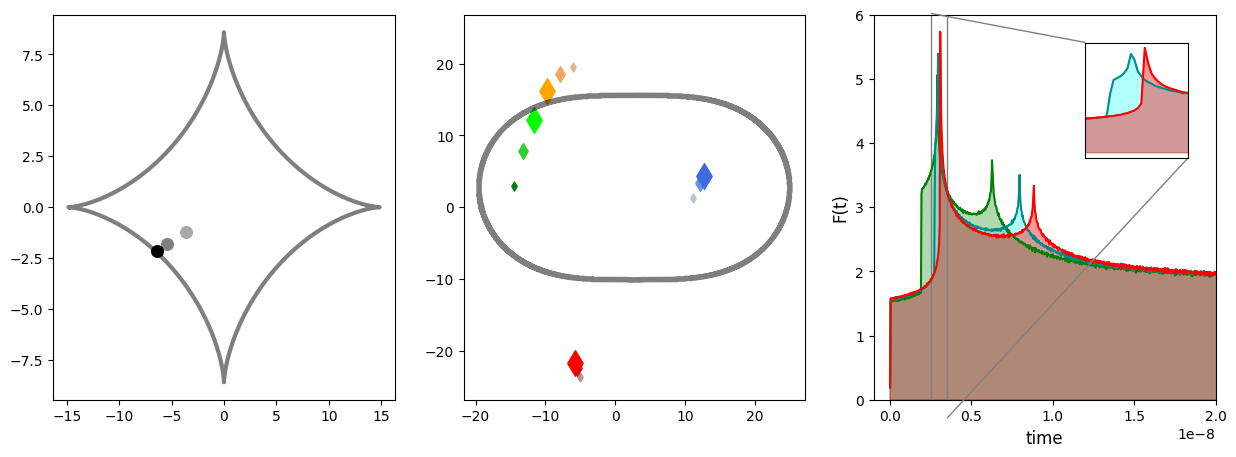

In [54]:
colorlist = ['green', 'orange', 'red']

fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

x = np.array(caus_ra[-1])
y = np.array(caus_dec[-1])
# points = np.array([ra_caustic_list, dec_caustic_list])

r = np.sqrt(x**2 + y**2)
theta = np.arctan2(y, x)  # Angle in radians
sorted_indices = np.argsort(theta)

ax[0].plot(x[sorted_indices] / microarcsec, y[sorted_indices] / microarcsec, color='black', linewidth=3, alpha=0.5)

mag = np.sqrt(mus[0][1]**2 + mus[0][2]**2)

indices = [0, 1, 2]
for i, index in enumerate(indices):
    ax[0].scatter(macro_ra1[index] / microarcsec, macro_dec1[index] / microarcsec, color=colorlist0[i], s=70)

# ax[0].set_ylim(-1.3e-10, 1.3e-10)
# ax[0].axis('off')

x = ra_crit_list - eta20
y = dec_crit_list - eta21

r = np.sqrt(x**2 + y**2)
theta = np.arctan2(y, x)  # Angle in radians

sorted_indices = np.argsort(theta)

ax[1].plot(x[sorted_indices] / microarcsec, y[sorted_indices] / microarcsec, color='black', linewidth=4, alpha=0.5)

mag = np.sqrt(mus[0][1]**2 + mus[0][2]**2)

for i, color in enumerate(colorlist):
    size = 21
    
    temp_mag = np.sqrt(mus[i][1]**2 + mus[i][2]**2)
    if temp_mag > mag:
        size = 21 * temp_mag / mag * 2

    ra = img_x[i]
    dec = img_y[i]
    # print(i)
    colors = colorlists[:, i]
    print(colors)
    for j in range(len(ra)):    
        print(j)
        ax[1].scatter((ra[j] - eta20) / microarcsec, (dec[j] - eta21) / microarcsec, s=size, color=colors[j], marker='d')

ax[1].set_ylim(-1.3e-10 / microarcsec, 1.3e-10 / microarcsec)
# ax[1].axis('off')

ax[2].plot(data[0][:], data_y[0][:], color='green')
ax[2].fill_between(data[0][:], data_y[0][:], color="green", alpha=0.3, label="Peak 1 Area")

ax[2].plot(data[1][:], data_y[1][:], color='darkcyan')
ax[2].fill_between(data[1][:], data_y[1][:], color="cyan", alpha=0.3, label="Peak 1 Area")

ax[2].plot(data[2][:], data_y[2][:], color='red')
ax[2].fill_between(data[2][:], data_y[2][:], color="red", alpha=0.4, label="Peak 1 Area")

# ax[2].axis('off')
ax[2].set_xlabel(r'time', fontsize=12)
ax[2].set_ylabel(r'F(t)', fontsize=12)
ax[2].set_xlim(-1e-9, 0.2e-7)
ax[2].set_ylim(0, 6)


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset

zoom_position = [2, 10, 2, 10]  # [x0, y0, width, height]

# Create a zoomed-in inset
axins = inset_axes(ax[2], width="30%", height="30%", loc='upper right', borderpad=2)
axins.plot(data[1][:], data_y[1][:], color='darkcyan')
axins.fill_between(data[1][:], data_y[1][:], color="cyan", alpha=0.3, label="Peak 1 Area")
axins.plot(data[2][:], data_y[2][:], color='red')
axins.fill_between(data[2][:], data_y[2][:], color="red", alpha=0.4, label="Peak 1 Area")

axins.set_xlim(2.5e-9, 3.5e-9)
axins.set_xticks([])
axins.set_yticks([])
# axins.axis('off')
# Mark the zoomed-in area on the main plot
mark_inset(ax[2], axins, loc1=2, loc2=4, fc="none", ec="0.5")


# Add Zoom-In Window
# import matplotlib.patches as patches

# # Define the zoom-in window position and size
# zoom_position = [1, 1, 0.4, 0.4]  # [left, bottom, width, height]
# zoom_xlim = [-1e-10, 1e-10]
# zoom_ylim = [2, 4]

# # Create the zoom-in window
# ax_zoom = fig.add_axes(zoom_position)
# # ax_zoom.plot(data[0][:], data_y[0][:], color='green')
# # ax_zoom.fill_between(data[0][:], data_y[0][:], color="green", alpha=0.3)
# ax_zoom.plot(data[10][:], data_y[10][:], color='darkcyan')
# ax_zoom.fill_between(data[10][:], data_y[10][:], color="cyan", alpha=0.3)
# ax_zoom.plot(data[12][:], data_y[12][:], color='red')
# ax_zoom.fill_between(data[12][:], data_y[12][:], color="red", alpha=0.4)
# # ax_zoom.set_xlim(zoom_xlim)
# # ax_zoom.set_ylim(zoom_ylim)
# # ax_zoom.set_title('Zoom-In View')
# ax_zoom.axis('off')

# # Add a rectangle to indicate the zoom-in area on the main plot
# rect = patches.Rectangle((zoom_xlim[0], zoom_ylim[0]), zoom_xlim[1] - zoom_xlim[0], zoom_ylim[1] - zoom_ylim[0], linewidth=1, edgecolor='black', facecolor='none')
# ax[2].add_patch(rect)

# plt.xlabel('ts')
# plt.ylabel('F(t)')

# plt.show()

plt.savefig('merging_all.png')

In [56]:
args[0] +=2

In [57]:
args[2]-=1

In [58]:
colorlists

array([['rosybrown', 'firebrick', 'red'],
       ['burlywood', 'sandybrown', 'orange'],
       ['green', 'limegreen', 'lime'],
       ['lightsteelblue', 'cornflowerblue', 'royalblue']], dtype='<U14')

2
58
84
185


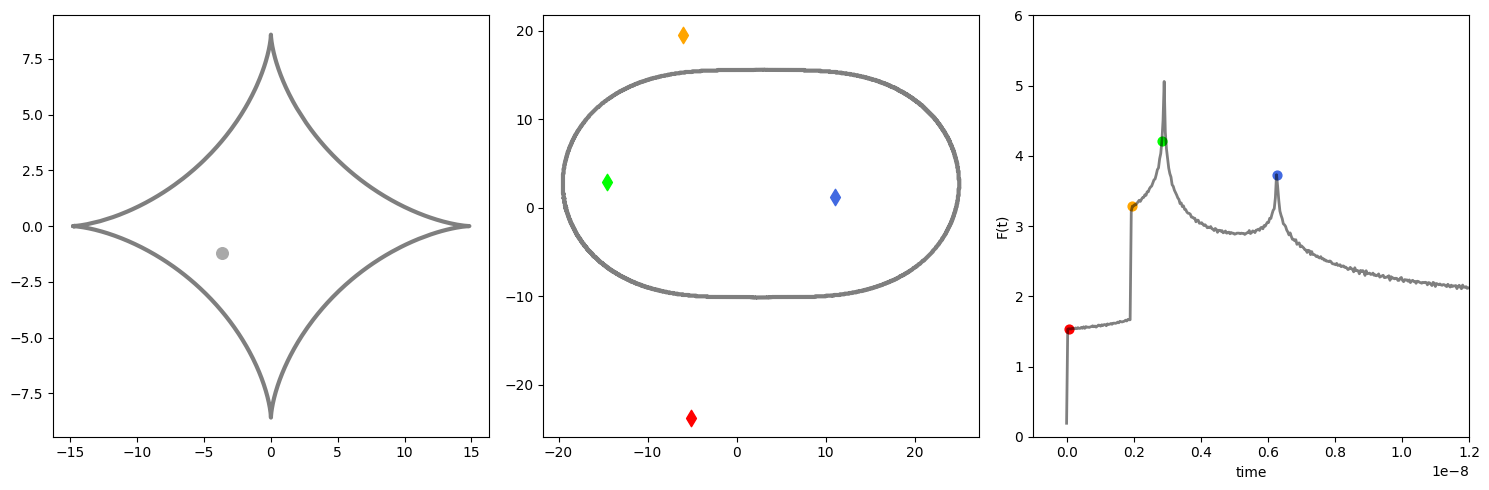

In [59]:
import matplotlib.image as mpimg
# img1 = mpimg.imread("caus.png")
# img2 = mpimg.imread("crits.png")

# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

x = np.array(caus_ra[-1])
y = np.array(caus_dec[-1])
# points = np.array([ra_caustic_list, dec_caustic_list])

r = np.sqrt(x**2 + y**2)
theta = np.arctan2(y, x)  # Angle in radians
sorted_indices = np.argsort(theta)

ax[0].plot(x[sorted_indices] / microarcsec, y[sorted_indices] / microarcsec, color='black', linewidth=3, alpha=0.5)

mag = np.sqrt(mus[0][1]**2 + mus[0][2]**2)

indices = [0, 10, 12]
# for i, index in (macro_ra1[0], macro_1[0]):
ax[0].scatter(macro_ra1[0] / microarcsec, macro_dec1[0] / microarcsec, color=colorlist0[0], s=70)

x = ra_crit_list - eta20
y = dec_crit_list - eta21

r = np.sqrt(x**2 + y**2)
theta = np.arctan2(y, x)  # Angle in radians

sorted_indices = np.argsort(theta)
ax[1].plot(x[sorted_indices] / microarcsec, y[sorted_indices] / microarcsec, color='black', linewidth=3, alpha=0.5)

j=0
for (x, y) in zip(img_x[0], img_y[0]):
    ax[1].scatter((x - eta20) / microarcsec, (y - eta21) / microarcsec, s=70, color=colorlists[j][-1], marker='d')
    j+=1
    # ax[1].scatter((img_x[0] - eta20) / microarcsec, (img_y[0] - eta21) / microarcsec, s=size, color=colors[0], marker='d')


ax[2].plot(data[0][:], data_y[0][:], color='black', linewidth=2, alpha=0.5)
ax[2].set_xlim(-1e-9, 0.12e-7)
ax[2].set_ylim(0, 6)
ax[2].set_xlabel('ts')
colorlist = ['red', 'orange', 'lime', 'royalblue']
for i, arg in enumerate(args):
    print(arg)
    ax[2].scatter(data[0][arg], data_y[0][arg], s=40, color=colorlist[i])
ax[2].set_ylabel('F(t)')
ax[2].set_xlabel('time')
# ax[2].axis('off')

# Adjust layout
plt.tight_layout()
plt.savefig('crit_caus_fixed.png')


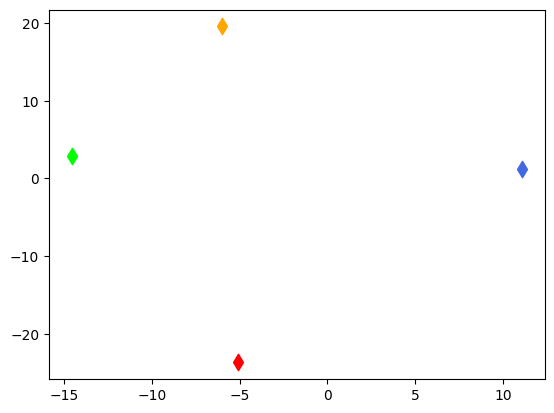

In [60]:
j=0
for (x, y) in zip(img_x[0], img_y[0]):
    plt.scatter((x - eta20) / microarcsec, (y - eta21) / microarcsec, s=70, color=colorlists[j][-1], marker='d')
    j+=1
    

In [61]:
colorlists

array([['rosybrown', 'firebrick', 'red'],
       ['burlywood', 'sandybrown', 'orange'],
       ['green', 'limegreen', 'lime'],
       ['lightsteelblue', 'cornflowerblue', 'royalblue']], dtype='<U14')

In [62]:
# ys = np.linspace(0.4, 1.7, 53)
ys = np.array([0.7, 0.9, 1.1])
ys = np.array([f"{y:.3f}".rstrip('0').rstrip('.') for y in ys], dtype=float)

In [63]:
np.where(ys==0.9)[0]

array([1])

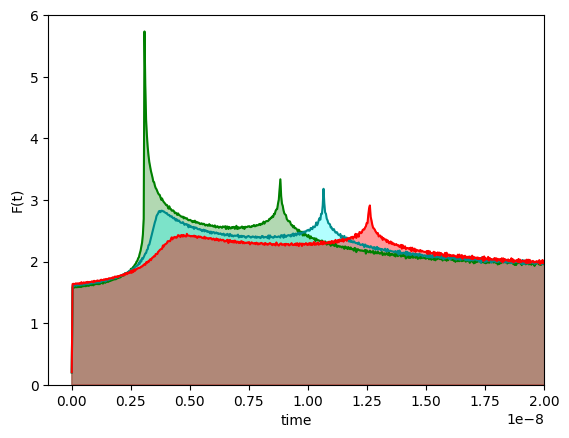

In [64]:
plt.plot(data[2][:], data_y[2][:], color='green')
plt.fill_between(data[2][:], data_y[2][:], color="green", alpha=0.3, label="Peak 1 Area")

plt.plot(data[3][:], data_y[3][:], color='darkcyan')
plt.fill_between(data[3][:], data_y[3][:], color="cyan", alpha=0.3, label="Peak 1 Area")

plt.plot(data[4][:], data_y[4][:], color='red')
plt.fill_between(data[4][:], data_y[4][:], color="red", alpha=0.4, label="Peak 1 Area")

plt.xlim(-1e-9, 0.2e-7)
plt.ylim(0, 6)
plt.xlabel('time')
plt.ylabel('F(t)')
plt.savefig('smoothening.png')


In [65]:
ws7 = np.loadtxt('./data_otto/0.7_ws.txt')
Fws7 = np.loadtxt('./data_otto/0.7_Fws.txt', dtype=complex, converters={0: lambda s: complex(s.decode().replace('+-', '-'))})

ws8 = np.loadtxt('./data_otto/0.8_ws.txt')
Fws8 = np.loadtxt('./data_otto/0.8_Fws.txt', dtype=complex, converters={0: lambda s: complex(s.decode().replace('+-', '-'))})

In [66]:
geo_array7 = np.loadtxt('./data_otto/0.7_geo.txt')
tds = geo_array7[0]
mus = geo_array7[1]
ns = geo_array7[2]
from wolensing.utils.utils import compute_geometrical
geoF7 = compute_geometrical(ws7, mus, tds, ns)

geo_array8 = np.loadtxt('./data_otto/0.8_geo.txt')
tds = geo_array8[0]
mus = geo_array8[1]
ns = geo_array8[2]
from wolensing.utils.utils import compute_geometrical
geoF8 = compute_geometrical(ws8, mus, tds, ns)

In [67]:
fac = np.sqrt(2.9999999980000025)

In [68]:
from pycbc.waveform import get_fd_waveform
import numpy as np
from scipy.integrate import simps
import pycbc.psd as psd
from scipy.interpolate import griddata
from bisect import bisect_left
from pycbc.filter.matchedfilter import overlap

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

import lal as _lal

import matplotlib.pyplot as plt
# import scienceplots
# plt.style.use('science')



hp, hc = get_fd_waveform(approximant = 'IMRPhenomD',
                         mass1 = 30,
                         mass2 = 30,
                         delta_f = .04,
                         f_lower = 10,
                         f_final = 2000)

dfnoise = 0.04
noiselen = int(2001/dfnoise)+1
noise2 = psd.analytical.aLIGOaLIGODesignSensitivityT1800044(noiselen, dfnoise, 1)
noisef = np.linspace(1, 1 + dfnoise*(noiselen-1), num = noiselen)

fs = hp.sample_frequencies
i = bisect_left(fs, 10)
j = bisect_left(fs, 1950)
fs = fs[i:j]
hp = hp[i:j]
hc = hc[i:j]
noise2interpolated = griddata(noisef, noise2, fs)

ylist = np.linspace(0.4, 1.7, 53)
ylist = np.array([f"{y:.3f}".rstrip('0').rstrip('.') for y in ylist], dtype=float)
match_wave = []
match_geo = []
match_between = []
# print(matchlist2D)
for i, y in enumerate(ylist):
    Fw = np.loadtxt(f'./data_otto/fold_[{y}]_Fw.txt', dtype=complex, converters={0: lambda s: complex(s.decode().replace('+-', '-'))})
    ws = np.loadtxt(f'./data_otto/fold_[{y}]_ws.txt')
    Finterpolated = griddata(ws, Fw, fs)
    # plt.semilogx(ws/(2*np.pi),np.angle(F), label = 'm = {}, y = {}'.format(mass, y))
    # plt.show()
    # print(Finterpolated)
    hpL1 = Finterpolated*hp
    # match_wave.append(hpL1.match(hp, psd = noise2, low_frequency_cutoff=10, high_frequency_cutoff=2000)[0])

    geo_array = np.loadtxt(f'data_otto/[{y}]_geo.txt')
    tds = geo_array[0]
    mus = geo_array[1]
    ns = geo_array[2]
    from wolensing.utils.utils import compute_geometrical
    geoF = compute_geometrical(ws, mus, tds, ns)
    Finterpolated = griddata(ws, geoF, fs)

    hpL2 = Finterpolated*hp
    # match_geo.append(hpL2.match(hp, psd = noise2, low_frequency_cutoff=10, high_frequency_cutoff=2000)[0])

    match_between.append(hpL1.match(hpL2, psd = noise2, low_frequency_cutoff=10, high_frequency_cutoff=2000)[0])

# np.savetxt('./matchlist.txt', matchlist)

# plt.plot(ylist, match_wave, label = 'Wave')
# plt.plot(ylist, match_between)
# plt.xlabel(r'$\eta_m (\theta_m)$')
# plt.ylabel(r'mismatch')
# plt.title(r'Mismatch between geo. optics and wave optics')
# crit = np.where(ylist==0.7)[0][0]
# plt.axvspan(ylist[0], ylist[crit], alpha=0.5, color='gray')
# # plt.savefig('mismatch_geo_wave.pdf')
# plt.show()

/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


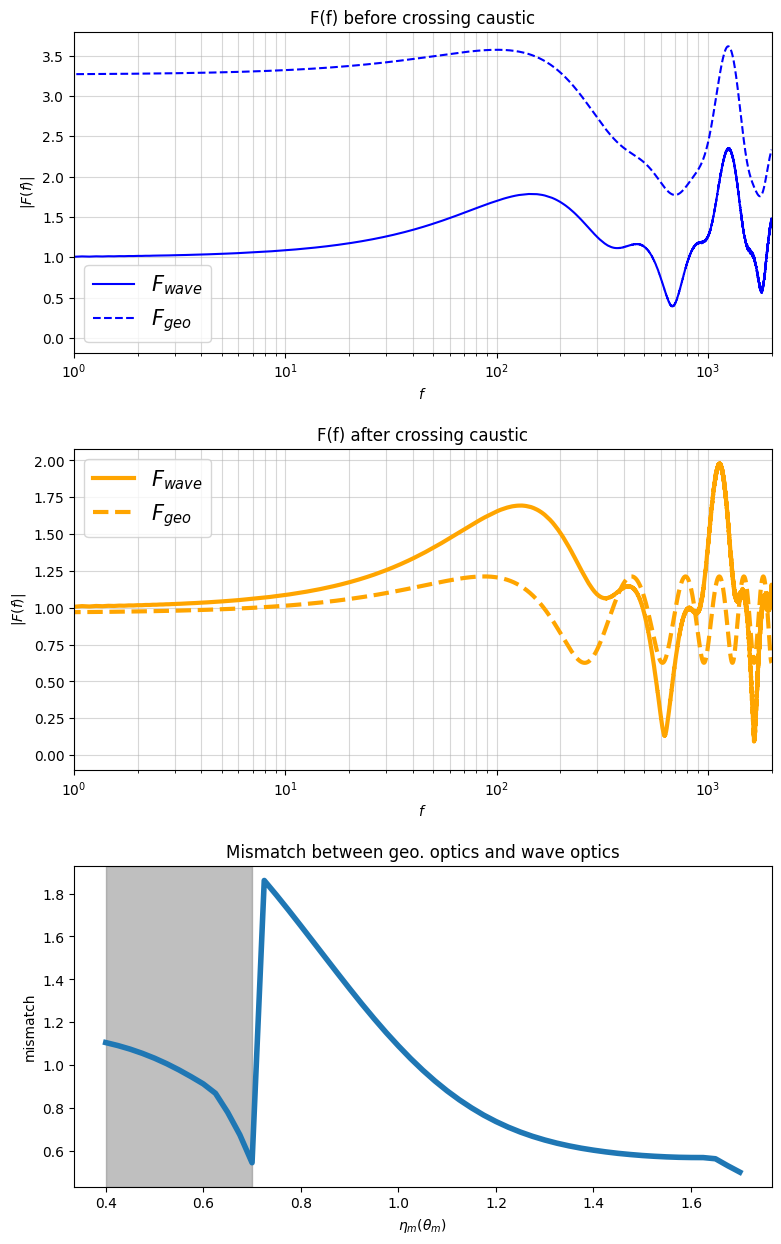

In [77]:
fig, ax = plt.subplots(3, 1, figsize=(9, 15))  # 2 rows, 1 column

ax[0].semilogx(ws7, np.abs(Fws7)/fac, label=r'$F_{wave}$', color='blue')    
ax[0].semilogx(ws7, np.abs(geoF7)/fac,label=r'$F_{geo}$', color='blue', linestyle='dashed')
ax[0].set_ylabel(r'$|F(f)|$')
ax[0].set_xlabel(r'$f$')
ax[0].grid(which='both', alpha=0.5)
ax[0].legend(fontsize=15)
ax[0].set_xlim(1, 2000)
ax[0].set_title(r'F(f) before crossing caustic')

ax[1].semilogx(ws8, np.abs(Fws8)/fac, label=r'$F_{wave}$', color='orange', linewidth=3)
ax[1].semilogx(ws8, np.abs(geoF8)/fac,label=r'$F_{geo}$', color='orange', linestyle='dashed', linewidth=3)
ax[1].set_ylabel(r'$|F(f)|$')
ax[1].set_xlabel(r'$f$')
ax[1].grid(which='both', alpha=0.5)
ax[1].legend(fontsize=15)
ax[1].set_xlim(1, 2000)
ax[1].set_title(r'F(f) after crossing caustic')

ones = np.ones(len(match_between))
ax[2].plot(ylist, (ones-match_between)*100, linewidth=4)
ax[2].set_xlabel(r'$\eta_m (\theta_m)$')
ax[2].set_ylabel(r'mismatch')
ax[2].set_title(r'Mismatch between geo. optics and wave optics')
crit = np.where(ylist==0.7)[0][0]
ax[2].axvspan(ylist[0], ylist[12], alpha=0.5, color='gray')
# plt.savefig('mismatch_geo_wave.pdf')
plt.subplots_adjust(hspace=0.3)
plt.show()

# plt.savefig('F_bf.pdf')